# Import necessary modules

In [1]:
!pip install -U imbalanced-learn
!pip install gensim

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Processing
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler

# gensim
import gensim
from gensim.models import Word2Vec

# nltk
from nltk import sent_tokenize, word_tokenize

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)
  Using cached gensim-3.8.3-cp36-cp36m-manylinux1_x86_64.whl (24.2 MB)
     |████████████████████████████████| 117 kB 946 kB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108249 sha256=1402459797a2c6d66dd572b68b97ec99aad1023ca466913bb6430a84c4a4df28
  Stored in directory: /home/jovyan/.cache/pip/wheels/8b/5e/70/42adcaea93c80417ec6accf7db1d6d02367ed02f2254cd5eef
Successfully built smart-open


# Prepare Data

In [2]:
df = pd.read_csv("clean_compiled_transcripts.csv", index_col = "Participant_ID")
df.head()

,Transcript,PHQ_Score,PHQ_Binary
Participant_ID,,,
300,good atlanta georgia um my parents um i love i...,2,0
301,thank you mmm k i good thank you i los angeles...,3,0
302,i fine yourself i los angeles california part ...,4,0
303,okay bout yourself california yeah oh well it ...,0,0
304,i good um los angeles california um cool weath...,6,0


## Load pretrained vector embeddings (skip if you have the numpy data)

In [3]:
if not Path('./GoogleNews-vectors-negative300.bin.gz').exists():
    !wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [4]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('Model loaded')

Model loaded
CPU times: user 50.8 s, sys: 5.29 s, total: 56.1 s
Wall time: 1min 6s


In [5]:
# averaging the word vectors per document

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
        # if the words are already vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)
    
    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

## Tokenization (skip if you have the numpy data)

In [6]:
def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in sent_tokenize(text, language='english'):
        for word in word_tokenize(sent, language='english'):
            tokens.append(word)
    return tokens

In [7]:
tokenized = df.apply(lambda r: w2v_tokenize_text(r['Transcript']), axis=1).values

## Split the dataset (skip if you have the numpy data)

In [8]:
X = word_averaging_list(wv, tokenized)
y = df.PHQ_Binary

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  del sys.path[0]


In [9]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test(X, y)

In [10]:
RANDOM_STATE = 42

# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train, y_train = us.fit_sample(X_train, y_train)

In [11]:
# shuffle the train data in unison because data is in order
# reduces poor performance during k-cross validation when sampling data

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 300), (45, 300), (82,), (45,))

In [12]:
np.save("X_train_mean_w2v.npy", X_train)
np.save("X_test_mean_w2v.npy", X_test)
np.save("y_train_mean_w2v.npy", y_train)
np.save("y_test_mean_w2v.npy", y_test)

## Load dataset 

In [13]:
X_train = np.load("X_train_mean_w2v.npy")
X_test = np.load("X_test_mean_w2v.npy")
y_train = np.load("y_train_mean_w2v.npy")
y_test = np.load("y_test_mean_w2v.npy")

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [14]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [15]:
def k_cross(input_model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model = clone(input_model) # prevents incremental fitting
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [16]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Logistic Regression 

best scores: f1 = 0.6154761904761904, recall = 0.6683333333333332
[0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.6347926267281105
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        31
           1       0.41      0.79      0.54        14

    accuracy                           0.58        45
   macro avg       0.62      0.63      0.57        45
weighted avg       0.70      0.58      0.59        45

Confusion Matrix: 
 [[15 16]
 [ 3 11]]


LogisticRegression(C=1000000, n_jobs=3)

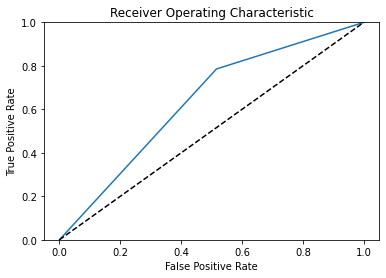

In [17]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_logreg_f1_model = find_best_logreg_model(6)
evaluate_model(best_logreg_f1_model)

## Decision Tree

best scores: f1 = 0.583051948051948, recall = 0.6933333333333334
[0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0
 0 1 0 0 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5472350230414746
              precision    recall  f1-score   support

           0       0.74      0.45      0.56        31
           1       0.35      0.64      0.45        14

    accuracy                           0.51        45
   macro avg       0.54      0.55      0.51        45
weighted avg       0.62      0.51      0.53        45

Confusion Matrix: 
 [[14 17]
 [ 5  9]]


DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)

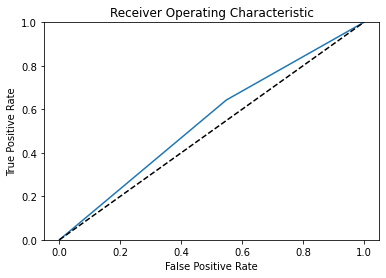

In [18]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_tree_f1_model = find_best_tree_model(20, 30)
evaluate_model(best_tree_f1_model)

## Random Forest

best scores: f1 = 0.5222222222222223, recall = 0.5866666666666667
[0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1
 1 1 0 0 0 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5956221198156681
              precision    recall  f1-score   support

           0       0.77      0.55      0.64        31
           1       0.39      0.64      0.49        14

    accuracy                           0.58        45
   macro avg       0.58      0.60      0.56        45
weighted avg       0.65      0.58      0.59        45

Confusion Matrix: 
 [[17 14]
 [ 5  9]]


RandomForestClassifier(n_estimators=21, random_state=42)

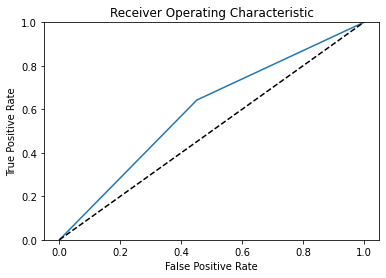

In [19]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_forest_f1_model = find_best_forest_model(30)
evaluate_model(best_forest_f1_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


f1 mean score: 0.5754273504273504
recall mean score: 0.735
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.5s finished


[0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1
 1 1 0 0 0 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.7223502304147466
              precision    recall  f1-score   support

           0       0.94      0.52      0.67        31
           1       0.46      0.93      0.62        14

    accuracy                           0.64        45
   macro avg       0.70      0.72      0.64        45
weighted avg       0.79      0.64      0.65        45

Confusion Matrix: 
 [[16 15]
 [ 1 13]]
Best SVM parameters: {'C': 10, 'kernel': 'linear'}


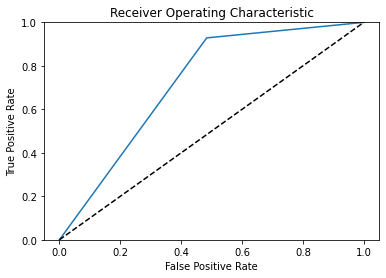

In [20]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")